In [331]:
import numpy as np
from scipy import misc
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_auc_score
from matplotlib import pylab as plt
import matplotlib.cm as cm
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
import re
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vianne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [74]:
#(a) parse data
data,labels = [],[]
for line in open('./data/amazon_cells_labelled.txt'):
    l = line.strip().split("\t")
    data.append(l[0])
    labels.append(l[1])
for line in open('./data/yelp_labelled.txt'):
    l = line.strip().split("\t")
    data.append(l[0])
    labels.append(l[1])
for line in open('./data/imdb_labelled.txt'):
    l = line.strip().split("\t")
    data.append(l[0])
    labels.append(l[1])
labels = np.array(labels)
data = np.array(data)

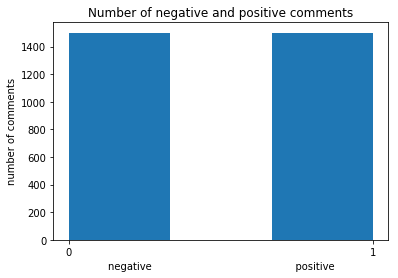

In [399]:
plt.hist(labels,bins=3)
plt.title('Number of negative and positive comments')
plt.ylabel('number of comments')
plt.xlabel('negative                                              positive')
plt.show()

Labels are balanced according to the readme.txt file as well as the plot above.
The first column of all three data files are parsed into a 1d numpy array (data) and the second column into another 1d numpy array (label).

In [76]:
#(b) Preprocessing
#lowercase all of the words
data = np.char.lower(data)

#stripping punctuation
for i in range(len(data)):
    data[i] = re.sub('[^\w\s]',' ', data[i])

#lemmatizing and remove stop words
stemmer = PorterStemmer()
for i in range(len(data)):
    s = []
    for word in data[i].split():
        if word not in set(stopwords.words('english')):
            s.append(stemmer.stem(word))
    data[i] = " ".join(s)

In [77]:
#(c) Split training and testing set
train_data,train_labels = [],[]
test_data, test_labels = [],[]
for i in range(0,3):
    start = i*1000
    count0 = 0
    count1 = 0
    for j in range(0,1000):
        if labels[start+j] == '0':
            if count0 < 400: 
                train_data.append(data[start+j])
                train_labels.append(0)
            else:
                test_data.append(data[start+j])
                test_labels.append(0)
            count0 += 1
        elif labels[start+j] == '1':
            if count1 < 400:
                train_data.append(data[start+j])
                train_labels.append(1)
            else:
                test_data.append(data[start+j])
                test_labels.append(1)
            count1 += 1


In [254]:
#(d)Bag of words
word_dict = dict()
ind=0
for sentence in train_data:
    for word in sentence.split():
        if word not in word_dict:
            word_dict[word]=ind
            ind+=1

train_bow = []
for sentence in train_data:
    sent_bow = [0]*len(word_dict)
    for word in sentence.split():
        sent_bow[word_dict[word]]+=1
    train_bow.append(sent_bow)
test_bow = []
for sentence in test_data:
    sent_bow = [0]*len(word_dict)
    for word in sentence.split():
        if word in word_dict:
            sent_bow[word_dict[word]]+=1
    test_bow.append(sent_bow)

If we loop through the test set when creating the word dictionary, and if there exists words present in the test set but not in the train set, then the feature will be 0 for all train samples.

In [401]:
#Visualize feature vectors for 2 reviews
# print(train_data[1])
# print(train_bow[1])
# print(train_data[2])
# print(train_bow[2])

In [287]:
#(e) Postprocessing
#L1 normalization of train_bow and test_bow
norm_train_bow, norm_test_bow = [],[]
for row in train_bow:
    if np.linalg.norm(row,ord=1)==0:
        norm_train_bow.append(row)
    else:
        norm_train_bow.append(row/np.linalg.norm(row,ord=1))
for row in test_bow:
    if np.linalg.norm(row,ord=1)==0:
        norm_test_bow.append(row)
    else:
        norm_test_bow.append(row/np.linalg.norm(row,ord=1))


In [276]:
# for i in range(len(train_bow)):
#     if train_bow[i] == [0]*len(word_dict):
#         print(train_labels[i])
# for i in range(len(test_bow)):
#     if test_bow[i] == [0]*len(word_dict):
#         print(test_labels[i])

In [408]:
#(f)
#plot function adapted from scikit-learn documentation
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j],horizontalalignment="center",color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def logistic_reg(xTr, yTr, xTe, yTe, dictionary):    
    lr = LogisticRegression()
    lr.fit(xTr, yTr)
    lr_acc = lr.score(xTe, yTe)
    lr_prob = lr.predict_proba(xTe)
    print("========================LR==========================")
    print("Logistic Regression Accuracy: {}".format(lr_acc))
    print("Logistic Regression AUC: {}".format(roc_auc_score(yTe,lr_prob[:,1])))
    # Confusion Matrix
    y_pred = lr.predict(xTe)
    cm = confusion_matrix(yTe, y_pred)
    print("Confusion matrix:")
    #print(cm)
    np.set_printoptions(precision=2)
    class_names = {"0", "1"}
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, title='LR confusion matrix')
    plt.show()
    
    # Show most significant words
    print("Most significant words:")
    indices = np.argsort(np.absolute(lr.coef_))[0]
    significant = [indices[-1], indices[-2], indices[-3], indices[-4], indices[-5],
              indices[-6], indices[-7], indices[-8], indices[-9], indices[-10]]     
    for i in significant:
        for w in dictionary.keys():
            if dictionary[w] == i:
                print(w)
                


========================LR==========================
Logistic Regression Accuracy: 0.775
Logistic Regression AUC: 0.872466666667
Confusion matrix:
Confusion matrix, without normalization
[[258  42]
 [ 93 207]]


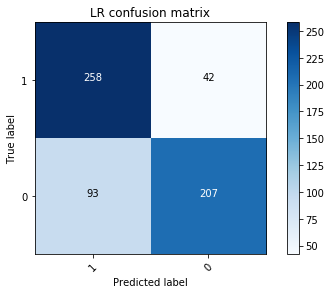

Most significant words:
great
bad
love
excel
good
nice
best
poor
wast
delici


In [409]:
logistic_reg(norm_train_bow, train_labels, norm_test_bow, test_labels, word_dict)


In [418]:
#NB models
def nb(xtr, ytr, xte, yte, dictionary):    
    #nb_gaussian = GaussianNB()
    nb_bernoulli = BernoulliNB()
    #nb_multinom = MultinomialNB()
    #nb_gaussian.fit(xtr, ytr)
    nb_bernoulli.fit(xtr, ytr)
    #nb_multinom.fit(xtr, ytr)
    prob = nb_bernoulli.predict_proba(xte)
    #acc_gaussian = nb_gaussian.score(xte, yte)
    acc_bernoulli = nb_bernoulli.score(xte, yte)
    #acc_multinom = nb_multinom.score(xte, yte)    
    #print("Gaussian NB Accuracy: {}".format(acc_gaussian))
    print("==================NB=====================")
    print("Bernoulli NB accuracy: {}".format(acc_bernoulli))
    print("Bernoulli NB AUC: {}".format(roc_auc_score(yte,prob[:,1])))
    #print("Multinomial NB: {}".format(acc_multinom))
    
    y_pred = nb_bernoulli.predict(xte)
    cm = confusion_matrix(yte, y_pred)
    print("Confusion matrix:")
    np.set_printoptions(precision=2)
    class_names = {"0", "1"}
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, title='NB confusion matrix')
    plt.show()
    
    # Show most significant words
    indices0 = np.argsort(np.absolute(nb_bernoulli.feature_log_prob_[0]))
    indices1 = np.argsort(np.absolute(nb_bernoulli.feature_log_prob_[1]))
    significant = [indices0[0], indices0[1], indices0[2], indices0[3], indices0[4],
              indices0[5], indices0[6], indices0[7], indices0[8], indices0[9]]     
    for i in significant:
        for w in dictionary.keys():
            if dictionary[w] == i:
                print(w)


==================NB=====================
Bernoulli NB accuracy: 0.811666666667
Bernoulli NB AUC: 0.882538888889
Confusion matrix:
Confusion matrix, without normalization
[[254  46]
 [ 67 233]]


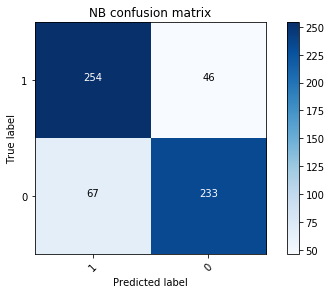

movi
bad
phone
time
would
great
good
film
phone
love


In [411]:
nb(norm_train_bow, train_labels, norm_test_bow, test_labels,word_dict)

In [309]:
#(g)N-gram model
def get_ngram(sentence,n):
    word_list = sentence.split()
    num_words = len(word_list)
    if (num_words < n):
        return [sentence]
    else:
        ngram = []
        for i in range(num_words - n + 1):
            ngram.append(" ".join(word_list[i:i+n]))
        return ngram
    
def build_ngram_model(xtr,xte,n):
    ngram_dict = dict()
    ind=0
    for sentence in xtr:
        for ngram in get_ngram(sentence,n):
            if ngram not in ngram_dict:
                ngram_dict[ngram]=ind
                ind+=1
    train_ngram=[]
    test_ngram=[]
    for sentence in xtr:
        feat=[0]*len(ngram_dict)
        for ngram in get_ngram(sentence,n):
            if ngram in ngram_dict:
                feat[ngram_dict[ngram]]+=1
        train_ngram.append(feat)
    for sentence in xte:
        feat=[0]*len(ngram_dict)
        for ngram in get_ngram(sentence,n):
            if ngram in ngram_dict:
                feat[ngram_dict[ngram]]+=1
        test_ngram.append(feat) 
    return train_ngram, test_ngram, ngram_dict



In [159]:
train_ngram, test_ngram, ngram_dict = build_ngram_model(train_data, test_data, 2)

In [414]:
# print(train_data[1])
# print(train_ngram[1])
# print(train_data[2])
# print(train_ngram[2])

In [168]:
# Postprocessing ngram model
#L1 normalization of train_ngram and test_ngram
norm_train_ngram, norm_test_ngram = [],[]
for row in train_ngram:
    if np.linalg.norm(row,ord=1)==0:
        norm_train_ngram.append(row)
    else:
        norm_train_ngram.append(row/np.linalg.norm(row,ord=1))
for row in test_ngram:
    if np.linalg.norm(row,ord=1)==0:
        norm_test_ngram.append(row)
    else:
        norm_test_ngram.append(row/np.linalg.norm(row,ord=1))


========================LR==========================
Logistic Regression Accuracy: 0.643333333333
Logistic Regression AUC: 0.704733333333
Confusion matrix:
Confusion matrix, without normalization
[[268  32]
 [182 118]]


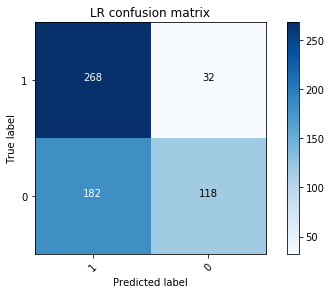

Most significant words:
work great
highli recommend
wast time
great phone
wast money
disappoint
great product
10 10
food good
easi use
==================NB=====================
Bernoulli NB accuracy: 0.646666666667
Bernoulli NB AUC: 0.699361111111
Confusion matrix:
Confusion matrix, without normalization
[[273  27]
 [185 115]]


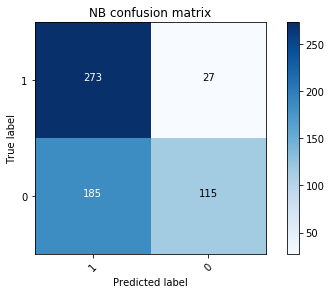

go back
wast time
custom servic
disappoint
wast money
work great
highli recommend
one best
sound qualiti
work well


In [415]:
logistic_reg(norm_train_ngram, train_labels, norm_test_ngram, test_labels, ngram_dict)
nb(norm_train_ngram, train_labels, norm_test_ngram, test_labels,ngram_dict)

In [269]:
#(h)PCA
    xtr = xtr-np.mean(xtr,axis=0)
    xte = xte-np.mean(xtr,axis=0)
    u,s,vh = np.linalg.svd(xtr,full_matrices=True)
    v = vh.T
    v = v[:,:n]
    #return np.matmul(np.dot(v,v.T),xtr)
    return np.dot(xtr,v), np.dot(xte,v)

In [272]:
# repeat (f)
norm_train_bow_10,norm_test_bow_10 = pca(norm_train_bow,norm_test_bow,10)
norm_train_bow_50,norm_test_bow_50 = pca(norm_train_bow,norm_test_bow,50)
norm_train_bow_100,norm_test_bow_100 = pca(norm_train_bow,norm_test_bow,100)

========================LR==========================
Logistic Regression Accuracy: 0.616666666667
Logistic Regression AUC: 0.684188888889
Confusion matrix:
Confusion matrix, without normalization
[[134 166]
 [ 64 236]]


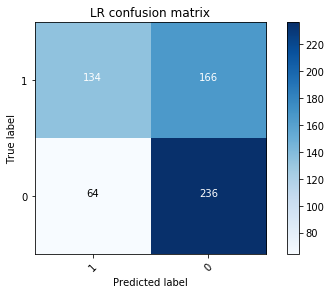

Most significant words:
way
plug
go
case
convert
valu
us
excel
good
unless
==================NB=====================
Bernoulli NB accuracy: 0.558333333333
Bernoulli NB AUC: 0.585627777778
Confusion matrix:
Confusion matrix, without normalization
[[130 170]
 [ 95 205]]


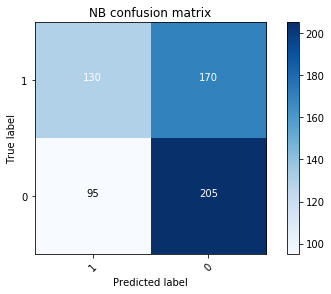

plug
convert
case
go
valu
good
excel
unless
way
us
========================LR==========================
Logistic Regression Accuracy: 0.675
Logistic Regression AUC: 0.775722222222
Confusion matrix:
Confusion matrix, without normalization
[[167 133]
 [ 62 238]]


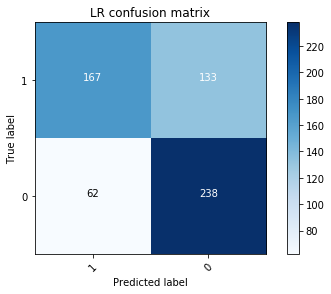

Most significant words:
way
plug
say
go
volum
fun
case
one
convert
sever
==================NB=====================
Bernoulli NB accuracy: 0.576666666667
Bernoulli NB AUC: 0.637361111111
Confusion matrix:
Confusion matrix, without normalization
[[ 95 205]
 [ 49 251]]


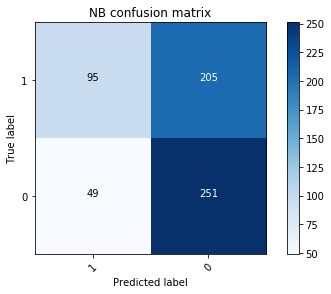

plug
convert
mic
45
case
minut
must
hundr
say
imagin
========================LR==========================
Logistic Regression Accuracy: 0.711666666667
Logistic Regression AUC: 0.809133333333
Confusion matrix:
Confusion matrix, without normalization
[[182 118]
 [ 55 245]]


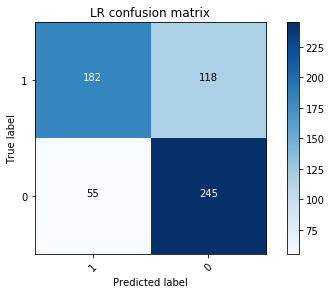

Most significant words:
way
plug
say
go
volum
fun
case
one
convert
sever
==================NB=====================
Bernoulli NB accuracy: 0.58
Bernoulli NB AUC: 0.662544444444
Confusion matrix:
Confusion matrix, without normalization
[[ 98 202]
 [ 50 250]]


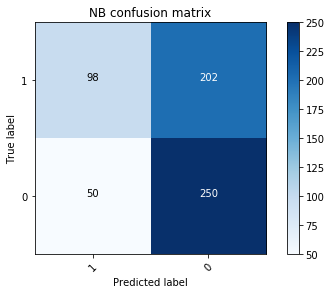

plug
convert
mic
45
case
minut
must
hundr
say
imagin


In [419]:
logistic_reg(norm_train_bow_10, train_labels, norm_test_bow_10, test_labels, word_dict)
nb(norm_train_bow_10, train_labels, norm_test_bow_10, test_labels, word_dict)
logistic_reg(norm_train_bow_50, train_labels, norm_test_bow_50, test_labels, word_dict)
nb(norm_train_bow_50, train_labels, norm_test_bow_50, test_labels, word_dict)
logistic_reg(norm_train_bow_100, train_labels, norm_test_bow_100, test_labels, word_dict)
nb(norm_train_bow_100, train_labels, norm_test_bow_100, test_labels, word_dict)

In [274]:
#repeat (g)
norm_train_ngram_10,norm_test_ngram_10 = pca(norm_train_ngram,norm_test_ngram,10)
norm_train_ngram_50,norm_test_ngram_50 = pca(norm_train_ngram,norm_test_ngram,50)
norm_train_ngram_100,norm_test_ngram_100 = pca(norm_train_ngram,norm_test_ngram,100)


========================LR==========================
Logistic Regression Accuracy: 0.531666666667
Logistic Regression AUC: 0.600077777778
Confusion matrix:
Confusion matrix, without normalization
[[ 24 276]
 [  5 295]]


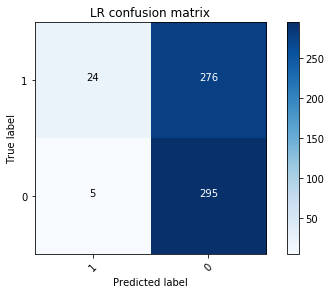

Most significant words:
plug us
excel valu
good case
go convert
way plug
us unless
tie charger
unless go
great jawbon
case excel
==================NB=====================
Bernoulli NB accuracy: 0.568333333333
Bernoulli NB AUC: 0.562377777778
Confusion matrix:
Confusion matrix, without normalization
[[198 102]
 [157 143]]


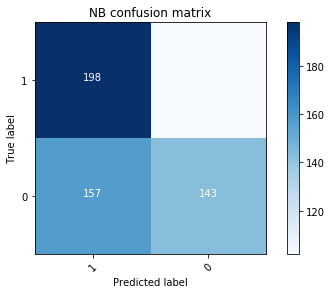

plug us
unless go
case excel
great jawbon
excel valu
tie charger
good case
go convert
way plug
us unless
========================LR==========================
Logistic Regression Accuracy: 0.535
Logistic Regression AUC: 0.546733333333
Confusion matrix:
Confusion matrix, without normalization
[[ 32 268]
 [ 11 289]]


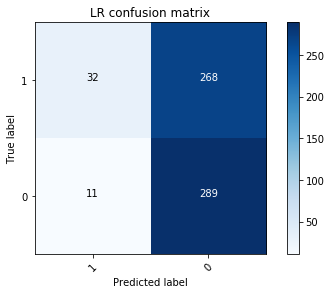

Most significant words:
plug us
excel valu
good case
mere 5
go convert
way plug
us unless
send one
tie charger
convers last
==================NB=====================
Bernoulli NB accuracy: 0.521666666667
Bernoulli NB AUC: 0.558816666667
Confusion matrix:
Confusion matrix, without normalization
[[263  37]
 [250  50]]


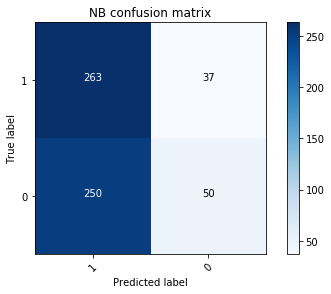

plug us
unless go
case excel
convers last
45 minut
line right
great jawbon
get decent
plug get
mic great
========================LR==========================
Logistic Regression Accuracy: 0.53
Logistic Regression AUC: 0.558861111111
Confusion matrix:
Confusion matrix, without normalization
[[ 62 238]
 [ 44 256]]


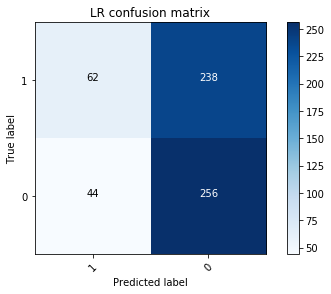

Most significant words:
plug us
excel valu
good case
mere 5
go convert
way plug
us unless
send one
tie charger
convers last
==================NB=====================
Bernoulli NB accuracy: 0.455
Bernoulli NB AUC: 0.457166666667
Confusion matrix:
Confusion matrix, without normalization
[[ 85 215]
 [112 188]]


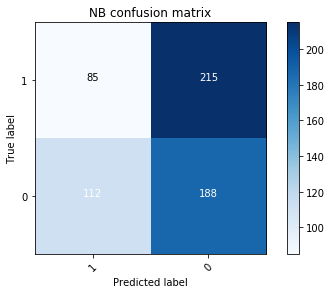

plug us
unless go
case excel
convers last
45 minut
line right
great jawbon
get decent
mic great
plug get


In [420]:
logistic_reg(norm_train_ngram_10, train_labels, norm_test_ngram_10, test_labels, ngram_dict)
nb(norm_train_ngram_10, train_labels, norm_test_ngram_10, test_labels, ngram_dict)
logistic_reg(norm_train_ngram_50, train_labels, norm_test_ngram_50, test_labels, ngram_dict)
nb(norm_train_ngram_50, train_labels, norm_test_ngram_50, test_labels, ngram_dict)
logistic_reg(norm_train_ngram_100, train_labels, norm_test_ngram_100, test_labels, ngram_dict)
nb(norm_train_ngram_100, train_labels, norm_test_ngram_100, test_labels, ngram_dict)

- For naive bayes, bag of words model gave the best AUC (0.88) and accuracy (0.812).
- For linear regression, PCA on bag of words (700 features) gave the best accuracy at 0.793, but bag of words gave the best AUC at 0.872.
- Another thing to consider is the speed of our classifier. Performing PCA on the bag of words model can speed up classification. We obtained 0.86 AUC and 0.77 accuracy using 300 features using linear regression, which is quite close to that obtained using 3500 features with naive bayes.
- Another thing to note in linear regression is that after conducting PCA, the true negative rate increases while the true positive rate decreases. Hence, the desirability of each model depends on our goal as well.

- People often use keywords like great, excellent, good, best, love etc. to express positive, and poor, bad, waste etc. to express negative sentiment. However, there still are huge variations in vocabularies people use to express sentiment.  
